<a href="https://colab.research.google.com/github/diego2017003/knn_treeClassifier/blob/main/knn_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## KNN e Árvore de decisão
---
este trabalho tem por objetivo exercitar os conceitos dos modelos de aprendizado de máquina k nearest neighbors(knn) e Decision Tree Classifier. No decorrer do notebook iremos utilizar os dados previamente amostrados durante a prática de redução de dados, para mais informações relacionadas à base de dados utilizada é possível acessar o projeto anterior no seguinte [link](https://github.com/diego2017003/Aprendizado_de_Maquina_ReducaoDeDados). Neste notebook iremos utilizar a base original, a amostragem de 30% sem reposição, a amostragem estratificada de 50% e a amostragem estratificada de 70%. As 4 tabelas utilizadas estão disponiveis no repositório deste trabalho. O notebook irá ser dividido em 4 etapas, sendo elas: importação e padronização dos dados, analise exploratória(breve), knn e Árvore de decisão. 

### 1. Importação e padronização dos dados

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dados_originais = pd.read_csv('https://raw.githubusercontent.com/diego2017003/knn_treeClassifier/main/heart.csv?token=AHICD55RZU4G53PRUPRVB3DA4HQCS')
dados_amostra30 = pd.read_csv('https://raw.githubusercontent.com/diego2017003/knn_treeClassifier/main/amostra_30_sr.csv?token=AHICD57VCQG2JACG2W6CH6DA4HQEE')
dados_amostra50 = pd.read_csv('https://raw.githubusercontent.com/diego2017003/knn_treeClassifier/main/amostra_50_estratificada.csv?token=AHICD577TFMYIROBCPV67PDA4HQHY')
dados_amostra70 = pd.read_csv('https://raw.githubusercontent.com/diego2017003/knn_treeClassifier/main/amostra_70_estratificada.csv?token=AHICD52TMNHP253IGVDF243A4HQP4')


Como os dados amostrados já passaram por uma discretização de dois atributos categóricos, iremos aplicar o método de one label encoding também aos dados originais e criaremos uma variável chamada de "dados_originais_tratados" para representar os dados após padronizados.  

In [41]:
dados_originais_tratados = dados_originais.copy()
dados_originais_tratados.restecg.replace({0:'Normal',1:'Possui_anormalidade',2:'Provável_hipertrofia'}, inplace=True)
dados_originais_tratados.cp.replace({1:'Angina_tipica',2:'Angina_atipica',3:'Não_Angina',0:'Assintomatico'}, inplace=True)
dados_originais_tratados = pd.get_dummies(dados_originais_tratados , columns=['restecg','cp'] , prefix=['restecg_','cp_'])
dados_originais_tratados.describe()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,131.623762,246.264026,0.148515,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554,0.485149,0.501650,0.013201,0.287129,0.165017,0.471947,0.075908
std,9.082101,0.466011,17.538143,51.830751,0.356198,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835,0.500606,0.500824,0.114325,0.453171,0.371809,0.500038,0.265288
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,0.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,140.000000,274.500000,0.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
dados_amostra30.drop(columns=['Unnamed: 0'],inplace=True) #coluna de indices do dataframe que gerou o .csv
dados_amostra30.describe()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.0,91.000000,91.000000,91.000000,91.000000
mean,53.615385,0.692308,129.505495,238.395604,0.142857,149.175824,0.296703,1.087912,1.351648,0.813187,2.362637,0.538462,0.351648,0.648352,0.0,0.241758,0.186813,0.516484,0.054945
std,8.850322,0.464095,15.428238,47.376712,0.351866,25.375226,0.459335,1.243725,0.656144,1.074059,0.587206,0.501280,0.480130,0.480130,0.0,0.430521,0.391921,0.502497,0.229135
min,35.000000,0.000000,100.000000,157.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,45.500000,0.000000,120.000000,204.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,130.000000,234.000000,0.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,60.500000,1.000000,140.000000,262.500000,0.000000,167.500000,1.000000,1.700000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,71.000000,1.000000,178.000000,407.000000,1.000000,194.000000,1.000000,5.600000,2.000000,4.000000,3.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [43]:
dados_amostra50.drop(columns=['Unnamed: 0'],inplace=True) #coluna de indices do dataframe que gerou o .csv
dados_amostra50.describe()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina,output
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,54.715232,0.754967,132.059603,242.920530,0.165563,147.887417,0.344371,1.151656,1.344371,0.801325,2.331126,0.536424,0.450331,0.013245,0.284768,0.132450,0.523179,0.059603,0.543046
std,9.326934,0.431538,17.222943,54.418198,0.372925,23.115519,0.476744,1.204317,0.611516,1.089464,0.650352,0.500331,0.499183,0.114703,0.452806,0.340108,0.501125,0.237537,0.499801
min,34.000000,0.000000,94.000000,126.000000,0.000000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,1.000000,120.000000,208.500000,0.000000,130.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,130.000000,239.000000,0.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,61.500000,1.000000,143.000000,269.500000,0.000000,163.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,77.000000,1.000000,180.000000,564.000000,1.000000,194.000000,1.000000,5.600000,2.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
dados_amostra70.drop(columns=['Unnamed: 0'],inplace=True) #coluna de indices do dataframe que gerou o .csv
dados_amostra70.describe()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina,output
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,54.622642,0.669811,132.297170,245.023585,0.160377,149.702830,0.349057,0.967453,1.443396,0.811321,2.306604,0.476415,0.514151,0.009434,0.259434,0.174528,0.476415,0.089623,0.542453
std,8.996527,0.471394,17.403529,55.027821,0.367824,22.314032,0.477800,1.158086,0.616982,1.085127,0.619856,0.500626,0.500983,0.096898,0.439362,0.380462,0.500626,0.286316,0.499374
min,34.000000,0.000000,94.000000,126.000000,0.000000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,120.000000,207.750000,0.000000,135.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,130.000000,239.000000,0.000000,152.500000,0.000000,0.600000,2.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,61.250000,1.000000,140.000000,270.250000,0.000000,165.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,77.000000,1.000000,180.000000,564.000000,1.000000,192.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. Analise exploratória
---
Nesta parte do trabalho iremos analisar como está distribuida a idade das pessoas estudadas, com um histograma e também tentaremos enxegar como se dá a distribuição com base na chance de desenvolver um ataque cardíaco. Além disso, iremos realizar um scatter-plot com pairplot para os atributos numéricos no intuito de analisar como eles se comportam com relação ao "atributo alvo". No notebook em que ocorrem a amostragem possui uma breve descrição sobre os campos presentes no database, entretanto alguns atributos não foram específicados na descrição da base se seriam de carater numérico ou categórico, isso pode chegar a atrapalhar nosso modelo posteriormente. Devido a isso iremos tratar todos os atributos não binários como numéricos e caso não demonstrem possuir caracteristica de ordem iremos realizar o método do one label encoding para transfromalas em varáveis binárias. Os atributos Binários serão visualizados com gráficos de barra para vermos se a classe possui anormalidades aparentes com relação ao alvo. As visualizações serão realizadas para as quatro bases e portanto este tópico será dividido em 4. A análise vai se limitar aos dados originais já que a amostragem foi feita estratificada para manter a distribuição original dos atributos.

### 2.1 Dados originais
---

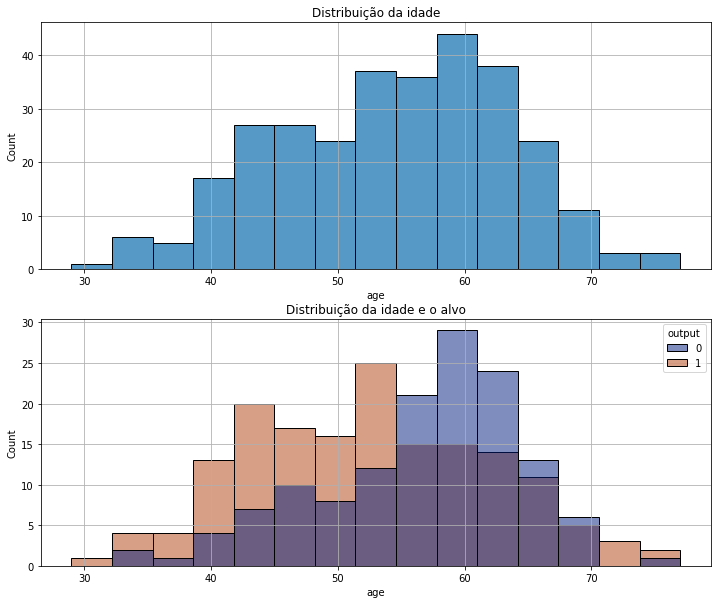

In [45]:
#visualização da idade
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.grid()
sns.histplot(data=dados_originais_tratados,x='age',bins=15).set_title("Distribuição da idade")
#visualização da idade
plt.subplot(2,1,2)
plt.grid()
sns.histplot(data=dados_originais_tratados,x='age',hue='output',bins=15,palette='dark').set_title("Distribuição da idade e o alvo")
plt.show()


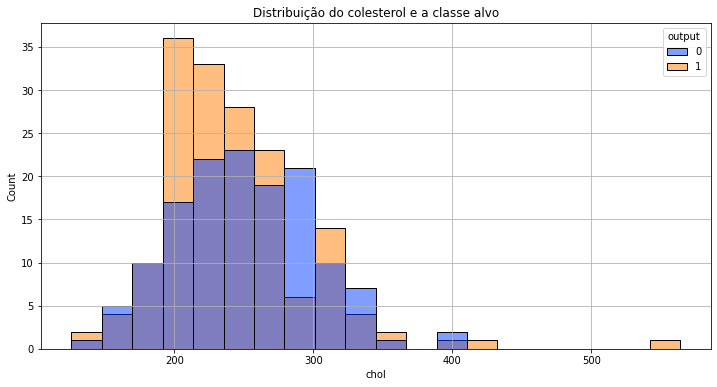

In [46]:
#visualização do cholesterol
plt.figure(figsize=(12,6))
plt.grid()
sns.histplot(data=dados_originais_tratados,x='chol',hue='output',bins=20,palette='bright').set_title("Distribuição do colesterol e a classe alvo")
plt.show()

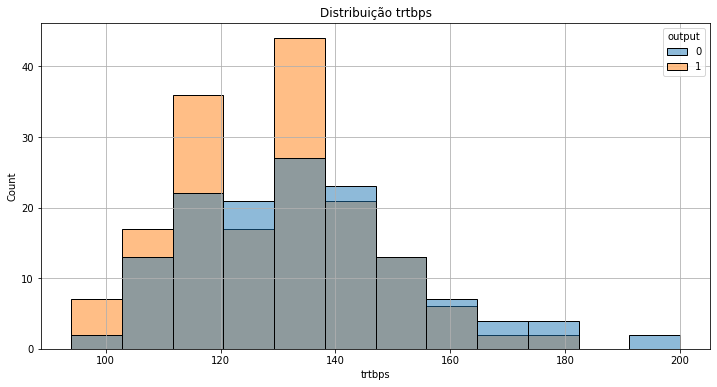

In [47]:
#visualização da trtbps
plt.figure(figsize=(12,6))
plt.grid()
sns.histplot(data=dados_originais_tratados,x='trtbps',hue='output',bins=12).set_title("Distribuição trtbps")
plt.show()

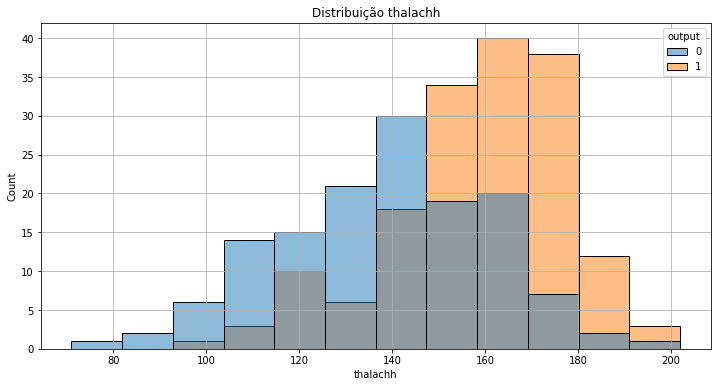

In [48]:
#visualização da thalach
plt.figure(figsize=(12,6))
plt.grid()
sns.histplot(data=dados_originais_tratados,x='thalachh',hue='output',bins=12).set_title("Distribuição thalachh")
plt.show()

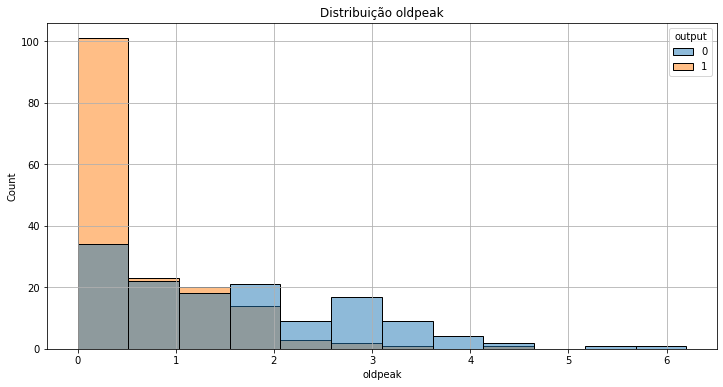

In [49]:
#visualização do oldpeak
plt.figure(figsize=(12,6))
plt.grid()
sns.histplot(data=dados_originais_tratados,x='oldpeak',hue='output',bins=12).set_title("Distribuição oldpeak")
plt.show()

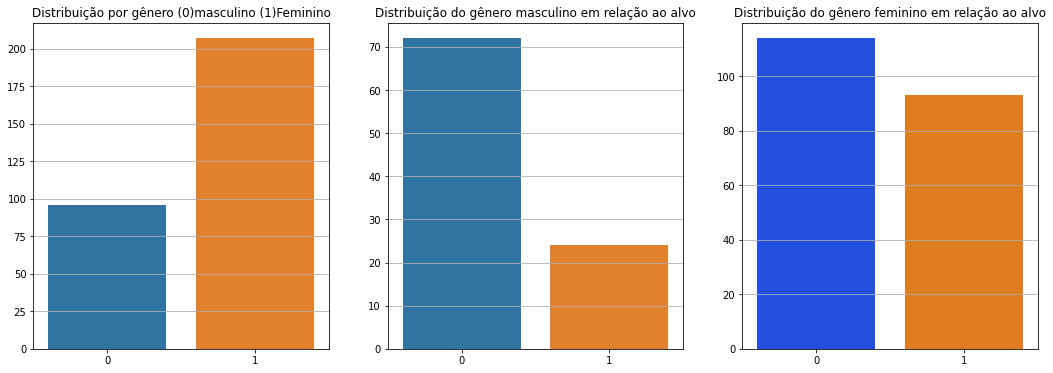

In [50]:
#visualização da dsitribuição por gênero
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.grid()
x = dados_originais_tratados.sex.value_counts()
sns.barplot(x=x.keys(),y=x.values).set_title("Distribuição por gênero (0)masculino (1)Feminino")
#visualização por gênero e a chance de ataque cardíaco
plt.subplot(1,3,2)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.sex==0,['output']]
x1 = x.value_counts()
sns.barplot(data=x1).set_title("Distribuição do gênero masculino em relação ao alvo")
plt.subplot(1,3,3)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.sex==1,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do gênero feminino em relação ao alvo")
plt.show()


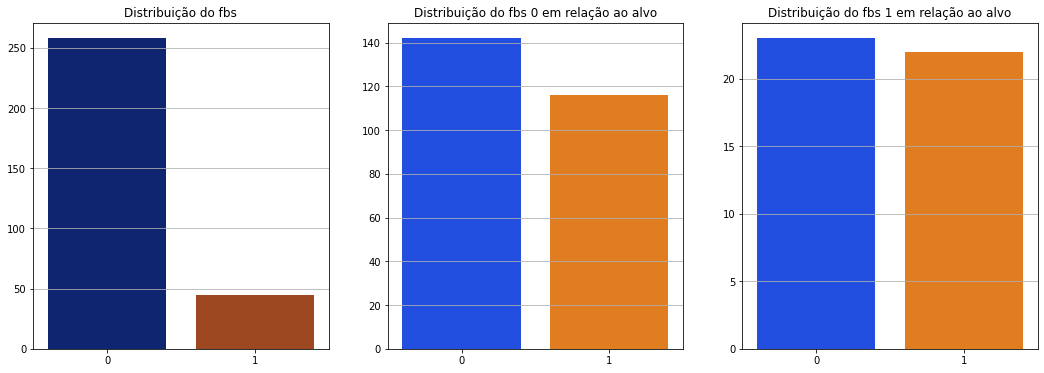

In [51]:
#visualização por fbs e a chance de ataque cardíaco
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.grid()
x = dados_originais_tratados.fbs.value_counts()
sns.barplot(x=x.keys(),y=x.values,palette='dark').set_title("Distribuição do fbs")
#visualização por fbs e a chance de ataque cardíaco
plt.subplot(1,3,2)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.fbs==0,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do fbs 0 em relação ao alvo")
#visualização por fbs e a chance de ataque cardíaco
plt.subplot(1,3,3)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.fbs==1,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do fbs 1 em relação ao alvo")
plt.show()

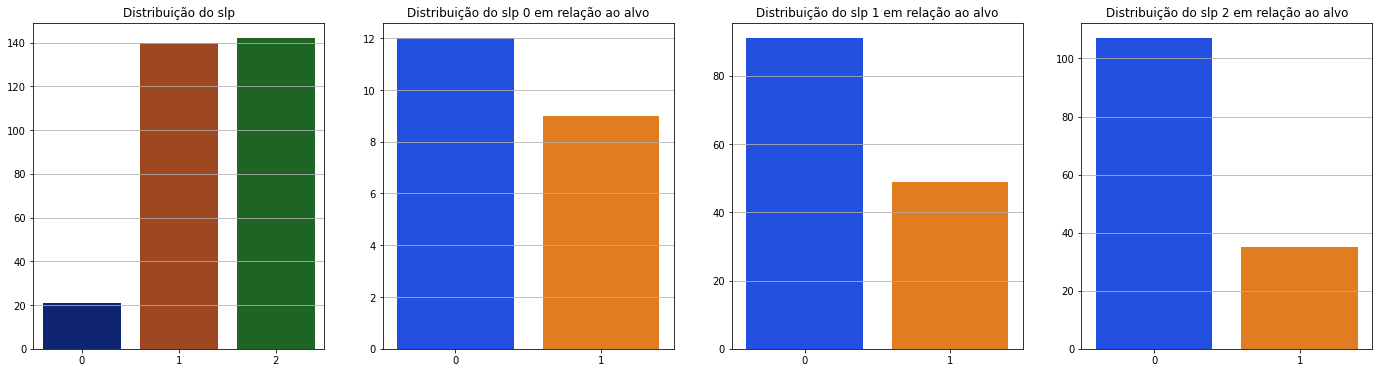

In [52]:
#visualização por slp 
plt.figure(figsize=(24,6))
plt.subplot(1,4,1)
plt.grid()
x = dados_originais_tratados.slp.value_counts()
sns.barplot(x=x.keys(),y=x.values,palette='dark').set_title("Distribuição do slp")
#visualização por slp 0 e a chance de ataque cardíaco
plt.subplot(1,4,2)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.slp==0,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do slp 0 em relação ao alvo")
#visualização por slp 1 e a chance de ataque cardíaco
plt.subplot(1,4,3)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.slp==1,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do slp 1 em relação ao alvo")
#visualização por slp 2 e a chance de ataque cardíaco
plt.subplot(1,4,4)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.slp==2,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do slp 2 em relação ao alvo")
plt.show()

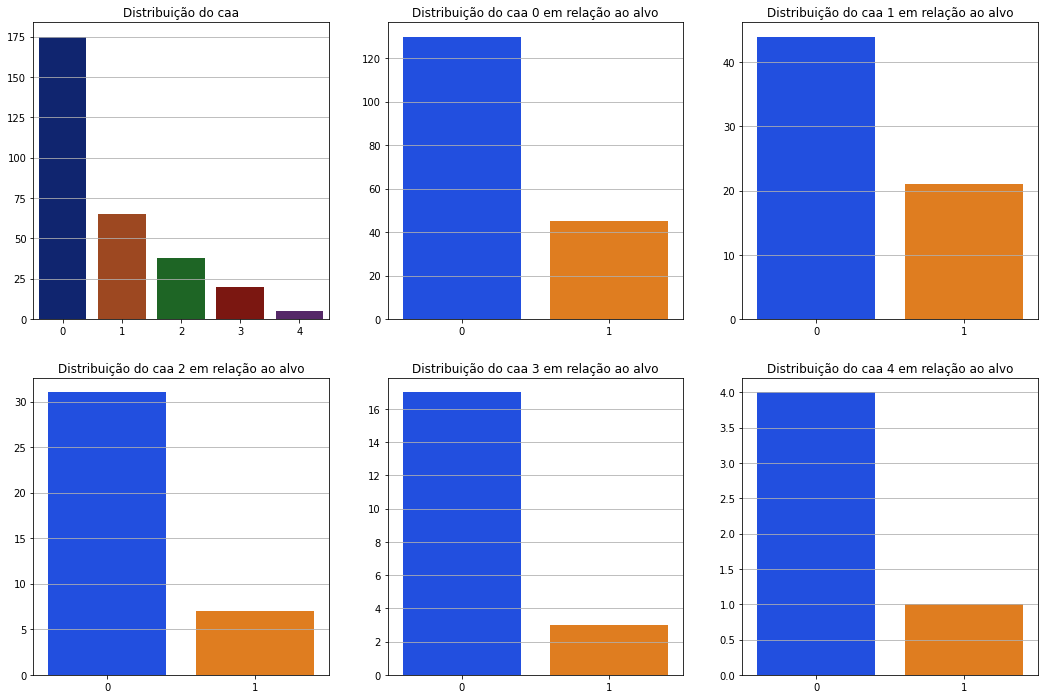

In [53]:
#visualização por 	caa  
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
plt.grid()
x = dados_originais_tratados.caa.value_counts()
sns.barplot(x=x.keys(),y=x.values,palette='dark').set_title("Distribuição do caa")
#visualização por caa 0 e a chance de ataque cardíaco
plt.subplot(2,3,2)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.caa ==0,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do caa 0 em relação ao alvo")
#visualização por caa 1 e a chance de ataque cardíaco
plt.subplot(2,3,3)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.caa==1,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do caa 1 em relação ao alvo")
#visualização por caa 2 e a chance de ataque cardíaco
plt.subplot(2,3,4)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.caa==2,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do caa 2 em relação ao alvo")
#visualização por caa 2 e a chance de ataque cardíaco
plt.subplot(2,3,5)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.caa==3,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do caa 3 em relação ao alvo")
#visualização por caa 2 e a chance de ataque cardíaco
plt.subplot(2,3,6)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.caa==4,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do caa 4 em relação ao alvo")
plt.show()

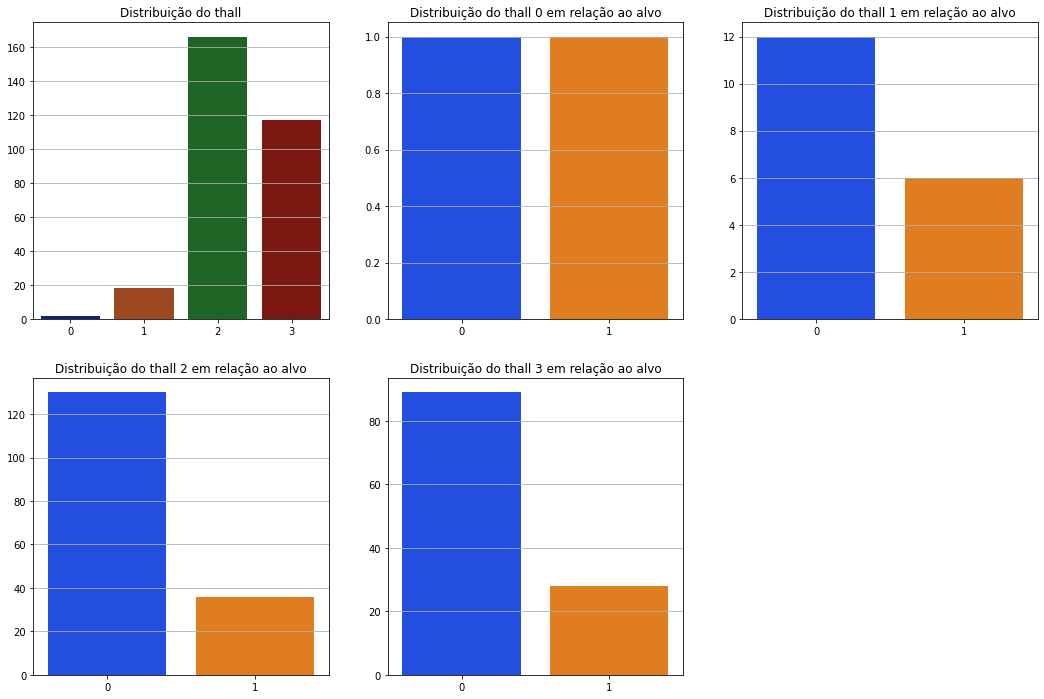

In [54]:
 	#visualização por thall  
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
plt.grid()
x = dados_originais_tratados.thall.value_counts()
sns.barplot(x=x.keys(),y=x.values,palette='dark').set_title("Distribuição do thall")
#visualização por thall 0 e a chance de ataque cardíaco
plt.subplot(2,3,2)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.thall ==0,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do thall 0 em relação ao alvo")
#visualização por thall 1 e a chance de ataque cardíaco
plt.subplot(2,3,3)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.thall==1,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do thall 1 em relação ao alvo")
#visualização por caa 2 e a chance de ataque cardíaco
plt.subplot(2,3,4)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.thall==2,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do thall 2 em relação ao alvo")
#visualização por  e a chance de ataque cardíaco
plt.subplot(2,3,5)
plt.grid()
x = dados_originais_tratados.loc[dados_originais_tratados.thall==3,['output']]
x1 = x.value_counts()
sns.barplot(data=x1,palette='bright').set_title("Distribuição do thall 3 em relação ao alvo")
plt.show()

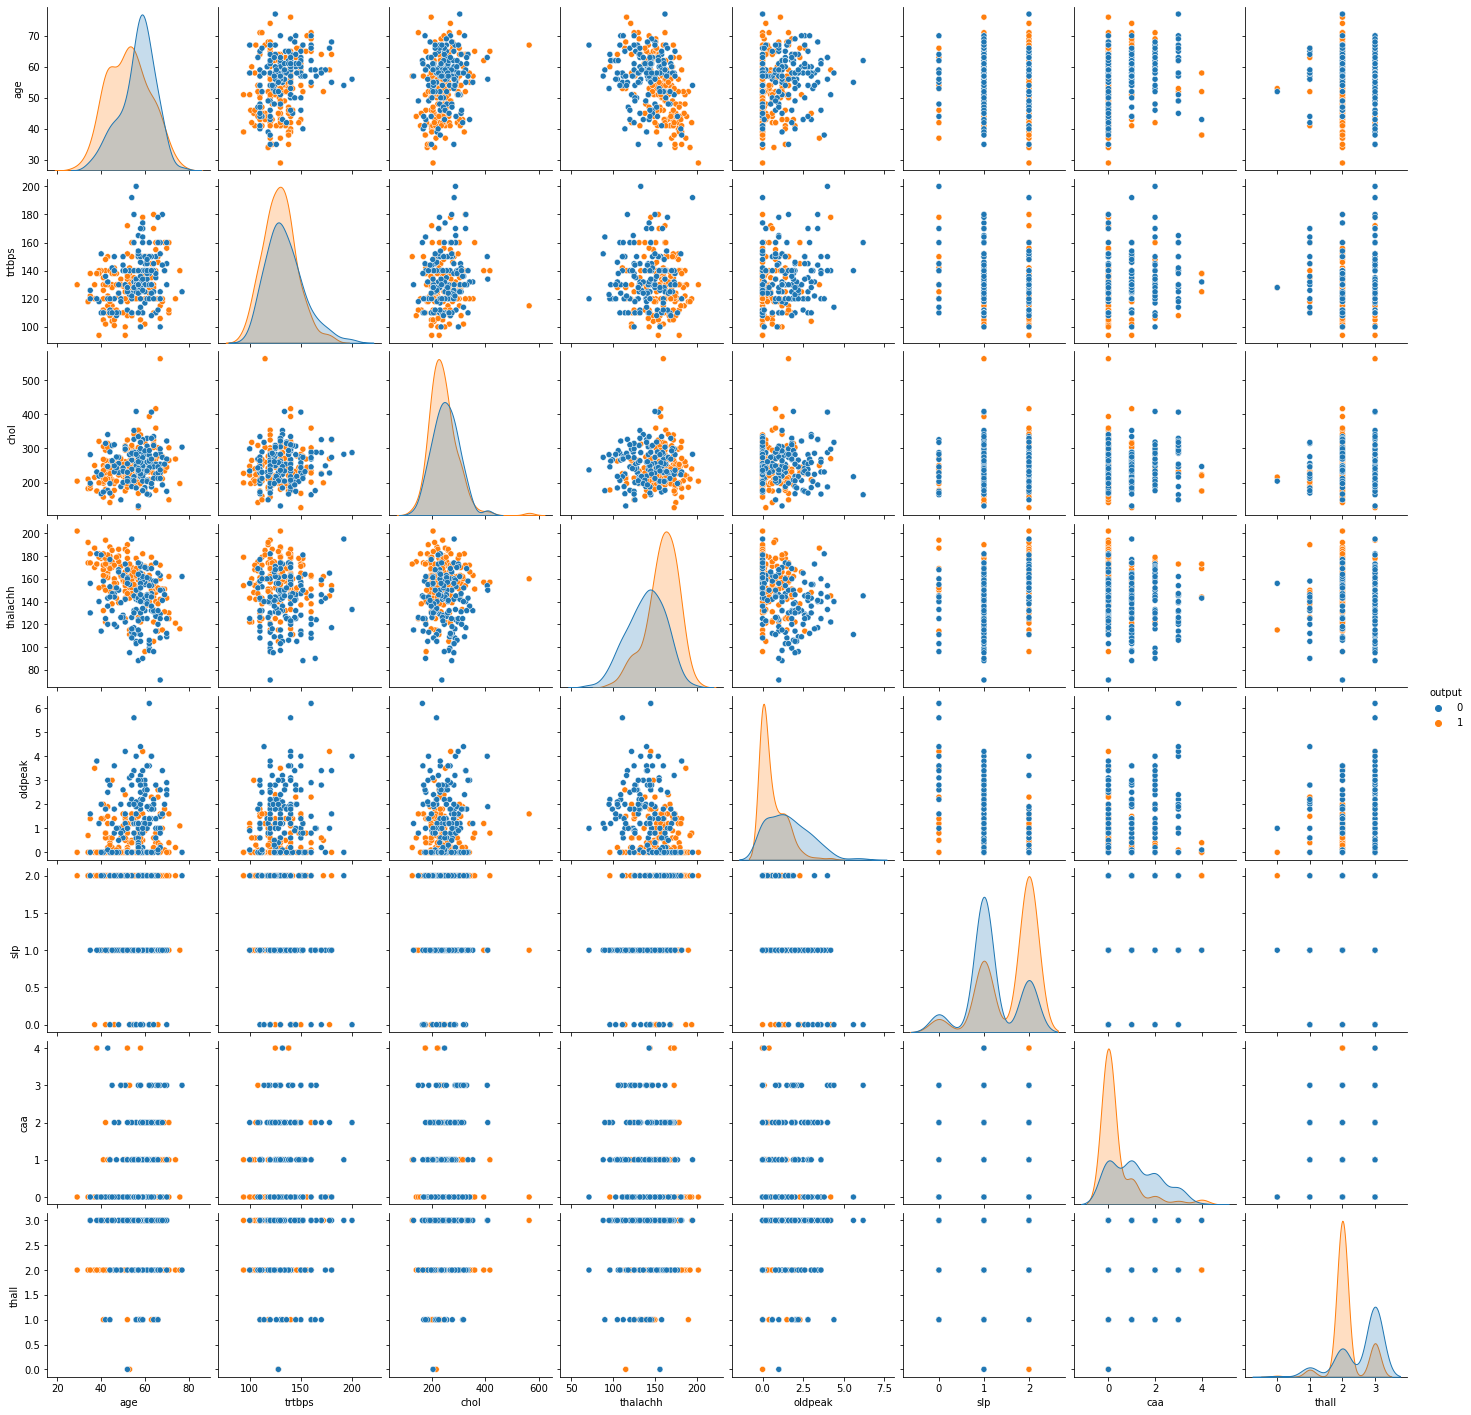

In [55]:
x = dados_originais_tratados.loc[:'output']
x = x.drop(columns=['sex','fbs','exng','restecg__Normal','restecg__Possui_anormalidade','restecg__Provável_hipertrofia','cp__Angina_atipica','cp__Angina_tipica','cp__Assintomatico','cp__Não_Angina'])
sns.pairplot(data=x,hue='output')

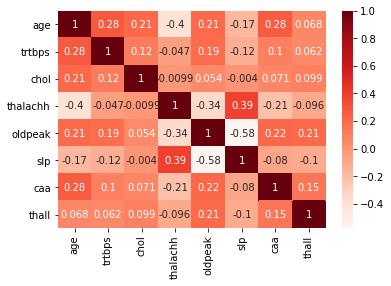

In [56]:
x = dados_originais_tratados.loc[:'output']
x = x.drop(columns=['output','sex','fbs','exng','restecg__Normal','restecg__Possui_anormalidade','restecg__Provável_hipertrofia','cp__Angina_atipica','cp__Angina_tipica','cp__Assintomatico','cp__Não_Angina'])
corr = x.corr()
sns.heatmap(data=corr,cmap='Reds',annot=True)


Como podemos visualizar, os atributos numéricos não possuem correlações fortes, dessa forma não podemos afirmar que eles interfiram entre si. além disso os valores que inicialmente dissemos ser numéricos por falta de informação se demostraram categóricos já que como número, não demonstraram significância ou sentido na ordem de grandeza. Da mesma forma, o "pairplot" mostra que além da baixa correlação, uma dificuldade de visualizar como a classe de saída interage com os atributos. 

Com base nos histogramas podemos observar que a distribuição dos atributos de idade e 'thalachh' é diferente quando levamos em consideração o atributo alvo, teoricamente podemos aferir que essas duas colunas são mais relevantes para o estudo proposto quando comparado aos demais atributos numéricos.

Já os dados categóricos ,nenhum demonstrou qualquer tipo de comportamento diferente quando levamos em consideração a classe alvo do problema. Portanto, inicialmente, não podemos gerar hipóteses bem formadas de como o comportamento dos atributos afetam a saída.


### 3. K Nearest Neighbors
---
Esta sessão irá criar e alterar diversos modelos utilizando o k-nn. Cada base de dados terá 20 valores de acurácia, sendo esses os resultados para 5 modelos com k indo de 1 a 5 e para cada modelo 4 formas de partição dos conjuntos de teste e de treinamento.  

#### 3.1 Pré-processamento
---
O k-nn é um modelo de aprendizado que utiliza a distância eucliadiana entre os dados já treinados para decidir a classe do novo dado que entrou no "treinamento", por utilizar a distância euclidiana este tipo de modelo é sensível à escala dos dados. Sendo assim, utilizaremos a biblioteca de pré processamento do scikit learn para normalizar toda nossa base de dados para possibilitar uma melhor performance dos modelos. A normalização utilizada pelo sklearn tem por intuito reduzir a média para 0 e o desvio padrão para 1, nós perderemos o significado numérico e categórico usual para o tipo de atributos que estamos lidando e será necessário a criação de uma rotina de pré-processamento caso formos aplicar o modelo em alum ambiente de produção. Como este notebook tem caráter de estudo, faremos essa normalização sem muitas preocupações. Vale salientar, que para o k-nn também iremos aplicar o "one hot encoding" para tranformar as variaveis categóricas em binárias. 

In [57]:
dados_originais_tratados = pd.get_dummies(dados_originais_tratados , columns=['slp','thall','caa'] , prefix=['slp_','thall_','caa_'])
dados_originais_tratados.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,output,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina,slp__0,slp__1,slp__2,thall__0,thall__1,thall__2,thall__3,caa__0,caa__1,caa__2,caa__3,caa__4
0,63,1,145,233,1,150,0,2.3,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0
1,37,1,130,250,0,187,0,3.5,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2,41,0,130,204,0,172,0,1.4,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,56,1,120,236,0,178,0,0.8,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0
4,57,0,120,354,0,163,1,0.6,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0


In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [60]:
dados_originais_normalizados = dados_originais_tratados.drop(columns=['output'])
mapper = DataFrameMapper([(dados_originais_normalizados.columns, StandardScaler())])
scaled_features = mapper.fit_transform(dados_originais_normalizados.copy())
scaled_features_df = pd.DataFrame(scaled_features, index=dados_originais_normalizados.index, columns=dados_originais_normalizados.columns)
dados_originais_normalizados = scaled_features_df.copy()
dados_originais_normalizados['output'] = dados_originais_tratados['output']
dados_originais_normalizados.describe().round(2)

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina,slp__0,slp__1,slp__2,thall__0,thall__1,thall__2,thall__3,caa__0,caa__1,caa__2,caa__3,caa__4,output
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.0,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.0,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.54
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50
min,-2.80,-1.47,-2.15,-2.32,-0.42,-3.44,-0.70,-0.90,-0.97,-1.0,-0.12,-0.63,-0.44,-0.95,-0.29,-0.27,-0.93,-0.94,-0.08,-0.25,-1.10,-0.79,-1.17,-0.52,-0.38,-0.27,-0.13,0.00
25%,-0.76,-1.47,-0.66,-0.68,-0.42,-0.71,-0.70,-0.90,-0.97,-1.0,-0.12,-0.63,-0.44,-0.95,-0.29,-0.27,-0.93,-0.94,-0.08,-0.25,-1.10,-0.79,-1.17,-0.52,-0.38,-0.27,-0.13,0.00
50%,0.07,0.68,-0.09,-0.12,-0.42,0.15,-0.70,-0.21,-0.97,1.0,-0.12,-0.63,-0.44,-0.95,-0.29,-0.27,-0.93,-0.94,-0.08,-0.25,0.91,-0.79,0.86,-0.52,-0.38,-0.27,-0.13,1.00
75%,0.73,0.68,0.48,0.55,-0.42,0.72,1.44,0.48,1.03,1.0,-0.12,1.58,-0.44,1.06,-0.29,-0.27,1.08,1.06,-0.08,-0.25,0.91,1.26,0.86,-0.52,-0.38,-0.27,-0.13,1.00
max,2.50,0.68,3.91,6.14,2.39,2.29,1.44,4.45,1.03,1.0,8.65,1.58,2.25,1.06,3.49,3.66,1.08,1.06,12.27,3.98,0.91,1.26,0.86,1.91,2.64,3.76,7.72,1.00


In [62]:
dados_amostra30_normalizado = dados_amostra30.drop(columns=['output'])
mapper = DataFrameMapper([(dados_amostra30_normalizado.columns, StandardScaler())])
scaled_features = mapper.fit_transform(dados_amostra30_normalizado.copy())
scaled_features_df = pd.DataFrame(scaled_features, index=dados_amostra30_normalizado.index, columns=dados_amostra30_normalizado.columns)
dados_amostra30_normalizado = scaled_features_df.copy()
dados_amostra30_normalizado['output'] = dados_amostra30['output']
dados_amostra30_normalizado.describe().round(2)

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina,output
count,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.0,91.00,91.00,91.00,91.00,91.00
mean,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.0,0.00,0.00,-0.00,-0.00,0.54
std,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,0.0,1.01,1.01,1.01,1.01,0.50
min,-2.12,-1.50,-1.92,-1.73,-0.41,-3.10,-0.65,-0.88,-2.07,-0.76,-2.33,-0.74,-1.36,0.0,-0.56,-0.48,-1.03,-0.24,0.00
25%,-0.92,-1.50,-0.62,-0.73,-0.41,-0.68,-0.65,-0.88,-0.54,-0.76,-0.62,-0.74,-1.36,0.0,-0.56,-0.48,-1.03,-0.24,0.00
50%,0.16,0.67,0.03,-0.09,-0.41,0.11,-0.65,-0.23,-0.54,-0.76,-0.62,-0.74,0.74,0.0,-0.56,-0.48,0.97,-0.24,1.00
75%,0.78,0.67,0.68,0.51,-0.41,0.73,1.54,0.49,0.99,0.17,1.09,1.36,0.74,0.0,-0.56,-0.48,0.97,-0.24,1.00
max,1.98,0.67,3.16,3.58,2.45,1.78,1.54,3.65,0.99,2.98,1.09,1.36,0.74,0.0,1.77,2.09,0.97,4.15,1.00


In [63]:
dados_amostra50_normalizado = dados_amostra50.drop(columns=['output'])
mapper = DataFrameMapper([(dados_amostra50_normalizado.columns, StandardScaler())])
scaled_features = mapper.fit_transform(dados_amostra50_normalizado.copy())
scaled_features_df = pd.DataFrame(scaled_features, index=dados_amostra50_normalizado.index, columns=dados_amostra50_normalizado.columns)
dados_amostra50_normalizado = scaled_features_df.copy()
dados_amostra50_normalizado['output'] = dados_amostra30['output']
dados_amostra50_normalizado.describe().round(2)

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina,output
count,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,91.00
mean,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.54
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50
min,-2.23,-1.76,-2.22,-2.16,-0.45,-2.51,-0.72,-0.96,-2.21,-0.74,-3.60,-1.08,-0.91,-0.12,-0.63,-0.39,-1.05,-0.25,0.00
25%,-0.83,0.57,-0.70,-0.63,-0.45,-0.75,-0.72,-0.96,-0.57,-0.74,-0.51,-1.08,-0.91,-0.12,-0.63,-0.39,-1.05,-0.25,0.00
50%,0.14,0.57,-0.12,-0.07,-0.45,0.18,-0.72,-0.29,-0.57,-0.74,-0.51,0.93,-0.91,-0.12,-0.63,-0.39,0.95,-0.25,1.00
75%,0.73,0.57,0.64,0.49,-0.45,0.66,1.38,0.54,1.08,0.18,1.03,0.93,1.10,-0.12,1.58,-0.39,0.95,-0.25,1.00
max,2.40,0.57,2.79,5.92,2.24,2.00,1.38,3.71,1.08,2.95,1.03,0.93,1.10,8.63,1.58,2.56,0.95,3.97,1.00


In [64]:
dados_amostra70_normalizado = dados_amostra70.drop(columns=['output'])
mapper = DataFrameMapper([(dados_amostra70_normalizado.columns, StandardScaler())])
scaled_features = mapper.fit_transform(dados_amostra70_normalizado.copy())
scaled_features_df = pd.DataFrame(scaled_features, index=dados_amostra70_normalizado.index, columns=dados_amostra70_normalizado.columns)
dados_amostra70_normalizado = scaled_features_df.copy()
dados_amostra70_normalizado['output'] = dados_amostra30['output']
dados_amostra70_normalizado.describe().round(2)

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,restecg__Normal,restecg__Possui_anormalidade,restecg__Provável_hipertrofia,cp__Angina_atipica,cp__Angina_tipica,cp__Assintomatico,cp__Não_Angina,output
count,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,212.00,91.00
mean,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.54
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50
min,-2.30,-1.42,-2.21,-2.17,-0.44,-2.68,-0.73,-0.84,-2.34,-0.75,-3.73,-0.95,-1.03,-0.10,-0.59,-0.46,-0.95,-0.31,0.00
25%,-0.74,-1.42,-0.71,-0.68,-0.44,-0.65,-0.73,-0.84,-0.72,-0.75,-0.50,-0.95,-1.03,-0.10,-0.59,-0.46,-0.95,-0.31,0.00
50%,0.15,0.70,-0.13,-0.11,-0.44,0.13,-0.73,-0.32,0.90,-0.75,-0.50,-0.95,0.97,-0.10,-0.59,-0.46,-0.95,-0.31,1.00
75%,0.74,0.70,0.44,0.46,-0.44,0.69,1.37,0.55,0.90,0.17,1.12,1.05,0.97,-0.10,1.69,-0.46,1.05,-0.31,1.00
max,2.49,0.70,2.75,5.81,2.29,1.90,1.37,4.53,0.90,2.95,1.12,1.05,0.97,10.25,1.69,2.17,1.05,3.19,1.00


Podemos perceber que as classes binárias deixaram de ser '0' e '1' para poder gerar a média 0,  entretanto permanecem sendo categóricas com duas classes de valores diferentes.

### aplicando o K-nn
---

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [84]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
X = dados_originais_normalizados.drop(columns=['output'])
X_train,X_test,Y_train,Y_test = train_test_split(X,dados_originais_normalizados.output,test_size=0.3,stratify=dados_originais_normalizados.output)
neigh1.fit(X_train,Y_train)
y_pred = neigh1.predict(X_test)
acuracia1 = accuracy_score(Y_test,y_pred)
print("Acuracia para n=1,70/30 :",acuracia1)
neigh2 = KNeighborsClassifier(n_neighbors=1)
X_train,X_test,Y_train,Y_test = train_test_split(X,dados_originais_normalizados.output,test_size=0.2,stratify=dados_originais_normalizados.output)
neigh2.fit(X_train,Y_train)
y_pred = neigh2.predict(X_test)
acuracia2 = accuracy_score(Y_test,y_pred)
print("Acuracia para n=1,80/20 :",acuracia2)
neigh3 = KNeighborsClassifier(n_neighbors=1)
X_train,X_test,Y_train,Y_test = train_test_split(X,dados_originais_normalizados.output,test_size=0.2,stratify=dados_originais_normalizados.output)
neigh3.fit(X_train,Y_train)
y_pred = neigh3.predict(X_test)
acuracia3 = accuracy_score(Y_test,y_pred)
print("Acuracia para n=1,90/10 :",acuracia3)


Acuracia para n=1,70/30 : 0.7142857142857143
Acuracia para n=1,80/20 : 0.7540983606557377
Acuracia para n=1,90/10 : 0.819672131147541
